In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

In [3]:
# Load images
reload(dp)
seg_test = dp.load_seg(seg_test_path)
seg_train = dp.load_seg(seg_train_path)
seg_val = dp.load_seg(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

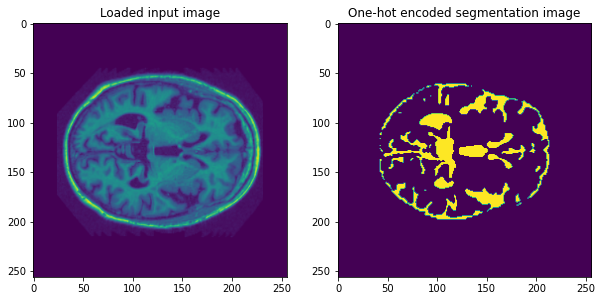

In [4]:
# Display loaded images
def display(title_list, image_list, cmap='viridis'):
    fig, ax = plt.subplots(1, len(title_list), figsize=(10, 10))
    for j, k in enumerate(title_list):
        ax[j].set_title(k)
    for j, k in enumerate(image_list):
        ax[j].imshow(k, cmap=cmap)
        plt.gray()
        
display(["Loaded input image", "One-hot encoded segmentation image"], [train[0], seg_train[0][:,:,1]])

In [5]:
print(np.array(train).shape)
print(np.array(seg_train).shape)

(9664, 256, 256, 1)
(9664, 256, 256, 4)


In [6]:
# Generate improved unet model
reload(iu)
model = iu.unet()

In [7]:
# Compile the model
reload(iu)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])

# model.compile(optimizer='adam', 
#               loss=iu.dice_loss, metrics=[iu.dice_coefficient_avg])

In [8]:
# Train the model
history = model.fit(np.array(train), np.array(seg_train), 
                    batch_size=20, epochs=8, 
                    validation_data=(np.array(val), np.array(seg_val)))

Train on 9664 samples, validate on 1120 samples
Epoch 1/8
9664/9664 [==============================] - 114s 12ms/step - loss: 0.0679 - dice_coefficient_avg: 0.9137 - val_loss: 0.0240 - val_dice_coefficient_avg: 0.9694
Epoch 2/8
9664/9664 [==============================] - 103s 11ms/step - loss: 0.0237 - dice_coefficient_avg: 0.9706 - val_loss: 0.0195 - val_dice_coefficient_avg: 0.9753
Epoch 3/8
9664/9664 [==============================] - 99s 10ms/step - loss: 0.0197 - dice_coefficient_avg: 0.9758 - val_loss: 0.0185 - val_dice_coefficient_avg: 0.9772
Epoch 4/8
9664/9664 [==============================] - 99s 10ms/step - loss: 0.0491 - dice_coefficient_avg: 0.9409 - val_loss: 0.0234 - val_dice_coefficient_avg: 0.9703
Epoch 5/8
9664/9664 [==============================] - 125s 13ms/step - loss: 0.0228 - dice_coefficient_avg: 0.9720 - val_loss: 0.0191 - val_dice_coefficient_avg: 0.9759
Epoch 6/8
9664/9664 [==============================] - 101s 10ms/step - loss: 0.0195 - dice_coefficient_

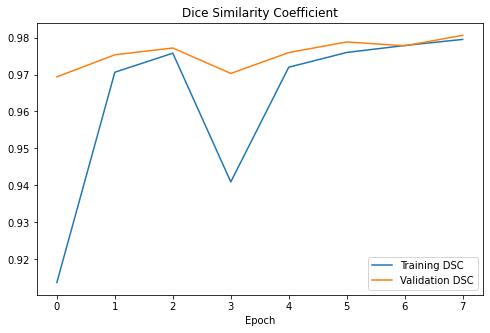

In [9]:
# Plot the training and validation DSC
plt.figure(figsize=(8, 5))
plt.title("Dice Similarity Coefficient")
plt.plot(history.history["dice_coefficient_avg"], label="Training DSC")
plt.plot(history.history["val_dice_coefficient_avg"], label="Validation DSC")
plt.xlabel("Epoch")
plt.legend();
plt.show()

In [12]:
# Calculate DSC
reload(iu)

prediction = model.predict(np.array(test))
tf.print("Average DSC for all labels: ", iu.dice_coefficient_avg(np.array(seg_test), np.array(prediction)))
tf.print("DSC for each label: ", iu.dice_coefficient(np.array(seg_test), np.array(prediction)))

Average DSC for all labels:  0.979654312
DSC for each label:  [0.975521207 0.975198448 0.976319909 ... 0.975556314 0.974554 0.975117]


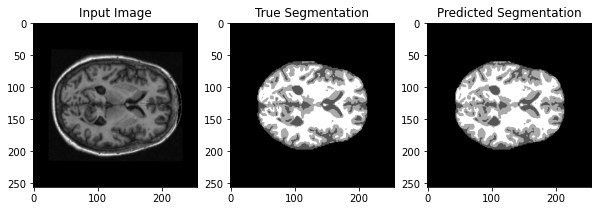

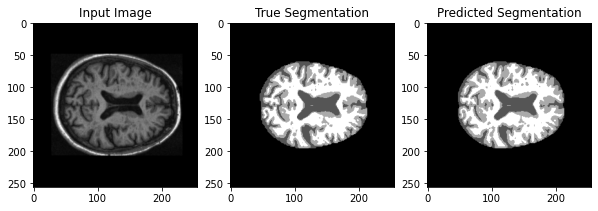

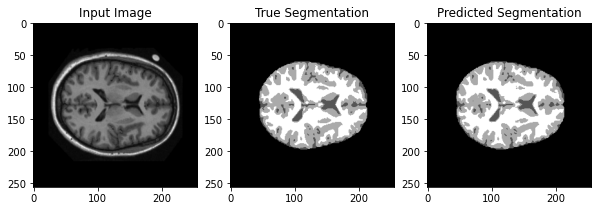

In [13]:
# Display random predictions
random_images = [random.randint(1,len(test)) for i in range(3)]

for i in random_images:
    display(['Input Image', 'True Segmentation', 'Predicted Segmentation'], 
            [test[i], tf.argmax(seg_test[i], axis=-1), tf.argmax(prediction[i], axis=-1)], cmap='gray')